In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

## Custom MC relations

You have the option of specifying custom mass-concentration relations parameterized as power laws in the peak height $\nu = \frac{\delta_c}{\sigma\left(M, z\right)}$, where $\sigma\left(M, z\right)$ is the mass variance of the matter power spectrum filtered on a scale $R \propto M^{\frac{1}{3}}$ (see https://arxiv.org/pdf/1909.02573.pdf for details). If you do not specify a custom model, the code defaults to Diemer&Joyce (2019) https://arxiv.org/pdf/1809.07326.pdf 

In [4]:
from pyHalo.preset_models import CDM

zlens, zsource = 0.5, 2.5
mc_model_kwargs = {'custom': True, 'c0': 100., 'beta': 0.8, 'zeta': -0.25} 
# For reference, CDM predicts something like c0 = 18, beta = 0.8, zeta = -0.2
realizationCDM = CDM(zlens, zsource)
realizationCDM_changeMC = CDM(zlens, zsource, mc_model=mc_model_kwargs)

In [5]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = realizationCDM.lensing_quantities()
lens_model_list_mc, lens_redshift_array_mc, kwargs_halos_mc, _ = realizationCDM_changeMC.lensing_quantities()
# you can ignore the last argument unless you're using a profile with numerically-computed deflection angles

from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationCDM.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)
lens_model_halos_only_changeMC = LensModel(lens_model_list_mc, zlens, zsource, lens_redshift_array_mc, cosmo=astropy_instance, multi_plane=True)

We can look at the projected mass to see the effect of changing the concentrations.

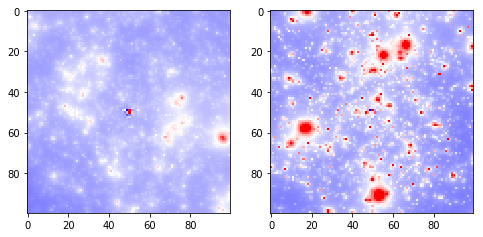

In [7]:
npix = 100 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)
kappa_subs_MC = lens_model_halos_only_changeMC.kappa(xx.ravel(), yy.ravel(), kwargs_halos_mc).reshape(shape0)

fig = plt.figure(1)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fig.set_size_inches(8,8)
ax1.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')
ax2.imshow(kappa_subs_MC, vmin=-0.1, vmax=0.1, cmap='bwr')